# **Transfer Learning with TensorFlow Part3: Scaling Up (🍔👀 Food Vision Mini)**

Objectives:


1.   Utilizing transfer learning: Feature extraction.
2.   Utilizing transfer learning: Fine Tunning.
3.   Build a "Food Vision mini" model to classify all the 101 classes in Food101 dataset with 10% of the training data.
4.   Baseline is to achieve 50.76% accuracy across 101 classes.



# **Project Preparation**


1.   Upload helper function to colab
2.   Upload Food101 10% dataset to colab
3.   Import dependences


In [160]:
import os
import random
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing

In [161]:
# Steps to upload file to google colab from local drive
from google.colab import files
data_to_load = files.upload()

Saving helper_functions.py to helper_functions (1).py


In [162]:
# Import series of helper function in this notebook
from helper_functions import create_tensorboard_callback, unzip_data, plot_loss_curves, compare_historys, walk_through_dir

In [ ]:
# Moutn gdrive to colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
file_name = "/content/gdrive/MyDrive/dataset/101_food_classes_10_percent.zip"
unzip_data(file_name)

In [163]:
walk_through_dir("/content/101_food_classes_10_percent")

There are 2 directories and 0 images in '/content/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/content/101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/prime_rib'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '/content/101_

# **Data Preprocessing**

In [164]:
# Creating training and test directory
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [165]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [166]:
train_data_all_10_percent = image_dataset_from_directory(train_dir,
                                                         label_mode="categorical",
                                                         image_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         image_size=IMG_SIZE,
                                         shuffle=False)

# Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# **Model Constrcution (Feature Extraction Model) utlizing Transfer Learning**

Steps to go:
1.   Create a `ModelCheckpoint` callback.
2.   Create a data augmentation layer into the model.
3.   Create a headness (no top layers) Functional EfficientNetB0 backbone-model (Output layer will be created separately)
4.   `Compile()` the model
5.   `Fit()` Feature extract for 5 full passes (5 epochs on the train dataset and validate only 15% of the test data dataset to save each epoch time).


## **1.   Create a `ModelCheckpoint` callback**

In [ ]:
# Setup checkpoint path
checkpoint_path = "101_classes_10_percent_data_model_checkpoint" 

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

## **2.   Create a data augmentation layer into the model**

In [ ]:
# Create data augmentation layer to incorporate it right into the model
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)
  # preprocessing.Rescaling(1/255.)                        
], name="data_augmentation")

## **3.   Create a headness (no top layers) Functional EfficientNetB0 backbone-model**

In [ ]:
# Creation of the base model and freeze its layers (Feature extraction)

# 1. Initialize input shape
input_shape = (224, 224, 3)

# 2.Initialize the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 3. Freezing the base model
base_model.trainable = False

# 4. Create input layer into the model
inputs = layers.Input(shape=input_shape, name="input_layer")

# 5. Add in data augmentation layer created above
x = data_augmentation(inputs)

# 6. Pass augmented inputs to the base model
x = base_model(x, training=False)

# 7. Pass the outputs features from base model to pooling layer to get a feature vector
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 8. Add the dense output layer
outputs = layers.Dense(len(train_data_all_10_percent.class_names), 
                       activation="softmax", 
                       name="output_layer")(x)

# 9. Create the complete model
model = tf.keras.Model(inputs, outputs)



16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of model created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


##  **4.   Compile the model**

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

## **5. Fit the model**


In [ ]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 130s 392ms/step - loss: 2.9136 - accuracy: 0.3164 - val_loss: 2.2857 - val_accuracy: 0.4211
Epoch 2/5
237/237 [==============================] - 71s 299ms/step - loss: 1.8445 - accuracy: 0.5175 - val_loss: 2.0713 - val_accuracy: 0.4637
Epoch 3/5
237/237 [==============================] - 67s 279ms/step - loss: 1.4743 - accuracy: 0.6121 - val_loss: 2.2222 - val_accuracy: 0.4428
Epoch 4/5
237/237 [==============================] - 62s 262ms/step - loss: 1.1735 - accuracy: 0.6793 - val_loss: 2.0891 - val_accuracy: 0.4791
Epoch 5/5
237/237 [==============================] - 61s 256ms/step - loss: 0.9721 - accuracy: 0.7303 - val_loss: 1.9570 - val_accuracy: 0.5246


In [ ]:
# Evaluate the feature extraction trained model with the whole set of test data
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 92s 117ms/step - loss: 1.8241 - accuracy: 0.5492


[1.824140191078186, 0.5492277145385742]

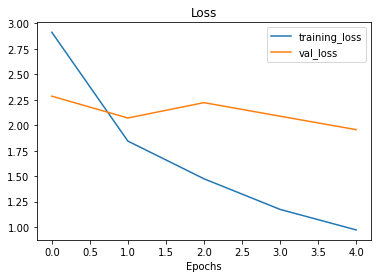

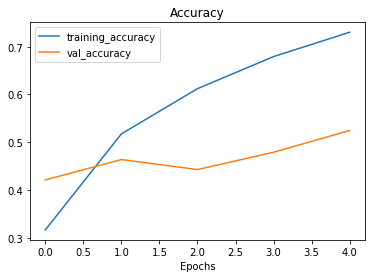

In [ ]:
# Plot the loss and accuracy curve
plot_loss_curves(history_all_classes_10_percent)

# **Perform Fine tuning on the Feature Extraction Base Model**

## **1. Un-freeze and Re-compile the model**

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Re-freeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Recompile the model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# Verifying which layers in the recompiled model is trainable

for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


## **2. Fine Tunning of the re-compiled model**

In [ ]:
# Fine tunning for additional 5 epochs
# The model already gone through 5 epochs training above and 10 is the total epochs desired
fine_tune_epochs = 10

# Fit the model for additional 5 epochs and starting from the weights left off from previous training
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 64s 248ms/step - loss: 0.6216 - accuracy: 0.8297 - val_loss: 1.9397 - val_accuracy: 0.5344
Epoch 6/10
237/237 [==============================] - 57s 239ms/step - loss: 0.5116 - accuracy: 0.8636 - val_loss: 1.9487 - val_accuracy: 0.5342
Epoch 7/10
237/237 [==============================] - 54s 226ms/step - loss: 0.4664 - accuracy: 0.8751 - val_loss: 1.9111 - val_accuracy: 0.5408
Epoch 8/10
237/237 [==============================] - 52s 216ms/step - loss: 0.4332 - accuracy: 0.8870 - val_loss: 1.9661 - val_accuracy: 0.5331
Epoch 9/10
237/237 [==============================] - 51s 212ms/step - loss: 0.4105 - accuracy: 0.8899 - val_loss: 1.9723 - val_accuracy: 0.5365
Epoch 10/10
237/237 [==============================] - 49s 206ms/step - loss: 0.3884 - accuracy: 0.8974 - val_loss: 1.9632 - val_accuracy: 0.5334


In [ ]:
# Evaluate the fine-tuned trained model with the whole set of test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 87s 110ms/step - loss: 1.6722 - accuracy: 0.5951


[1.6722465753555298, 0.5951287150382996]

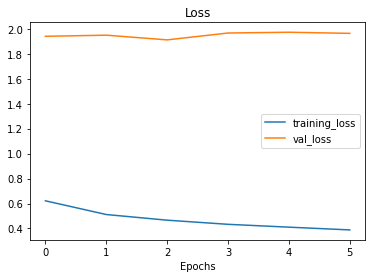

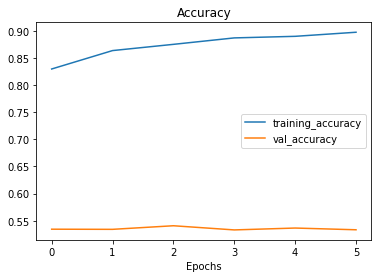

In [ ]:
# Plot the loss and accuracy curve
plot_loss_curves(history_all_classes_10_percent_fine_tune)

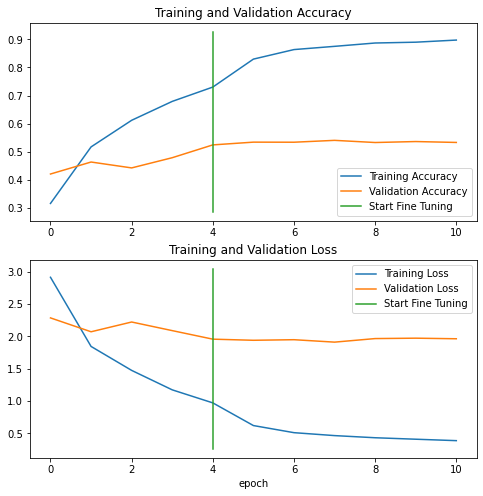

In [ ]:
compare_historys(history_all_classes_10_percent,
                 history_all_classes_10_percent_fine_tune)

# **Saving and loading trained model for furture use**

In [ ]:
model.save("/content/gdrive/MyDrive/TensorFlow_Deep_Learning/101_food_classes_10_percent_saved_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TensorFlow_Deep_Learning/101_food_classes_10_percent_saved_model/assets


In [ ]:
loaded_model = tf.keras.models.load_model("/content/gdrive/MyDrive/TensorFlow_Deep_Learning/101_food_classes_10_percent_saved_model")

In [ ]:
# Evaluate the loaded_model and compare performance to pre_saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 88s 110ms/step - loss: 1.6722 - accuracy: 0.5951


[1.6722465753555298, 0.5951287150382996]

In [ ]:
all_classes_10_percent_fine_tune_results

[1.6722465753555298, 0.5951287150382996]

# **Evaluating the performance of a pre-trained model across all different classes**

Use the pre-trained model to make some predictions, visualize them and find out which predictions were the **"the most wrong"**



In [ ]:
# Download a pre_trained model from github
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-08-07 02:17:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   131MB/s    in 0.3s    

2021-08-07 02:17:01 (131 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
# Unzip the model file
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in the pre-trained model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate the loaded pre-trained model with the whole test data set
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

# **Making predictions with the pre-trained model**

In [129]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 63s 80ms/step


In [130]:
len(test_data)

790

In [131]:
len(test_data) * BATCH_SIZE

25280

In [132]:
# How many prediction probability result?
len(preds_probs)

25250

In [133]:
# What is the shape of prediction probability?
preds_probs.shape

(25250, 101)

In [134]:
# Check out the first 10 predictions
preds_probs[:10]

array([[5.9542004e-02, 3.5742048e-06, 4.1376974e-02, ..., 1.4138707e-09,
        8.3530831e-05, 3.0897511e-03],
       [9.6401680e-01, 1.3753246e-09, 8.4780657e-04, ..., 5.4286997e-05,
        7.8362204e-12, 9.8466024e-10],
       [9.5925879e-01, 3.2533586e-05, 1.4866921e-03, ..., 7.1891071e-07,
        5.4397117e-07, 4.0275969e-05],
       ...,
       [4.7313261e-01, 1.2931220e-07, 1.4805585e-03, ..., 5.9750013e-04,
        6.6969093e-05, 2.3469209e-05],
       [4.4571821e-02, 4.7265530e-07, 1.2258515e-01, ..., 6.3498514e-06,
        7.5318521e-06, 3.6778734e-03],
       [7.2438997e-01, 1.9249742e-09, 5.2310865e-05, ..., 1.2291356e-03,
        1.5792692e-09, 9.6395699e-05]], dtype=float32)

In [135]:
# Check out the first prediction probability array
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.95420040e-02, 3.57420481e-06, 4.13769744e-02, 1.06605957e-09,
        8.16144308e-09, 8.66396554e-09, 8.09270432e-07, 8.56525787e-07,
        1.98590351e-05, 8.09776793e-07, 3.17278026e-09, 9.86737405e-07,
        2.85321876e-04, 7.80491949e-10, 7.42302276e-04, 3.89165252e-05,
        6.47403658e-06, 2.49773507e-06, 3.78911318e-05, 2.06783668e-07,
        1.55384660e-05, 8.15070223e-07, 2.62305161e-06, 2.00107237e-07,
        8.38273706e-07, 5.42161388e-06, 3.73908892e-06, 1.31505820e-08,
        2.77614570e-03, 2.80519434e-05, 6.85626778e-10, 2.55748546e-05,
        1.66889280e-04, 7.64068475e-10, 4.04528779e-04, 1.31506335e-08,
        1.79573601e-06, 1.44482021e-06, 2.30628569e-02, 8.24668518e-07,
        8.53658491e-07, 1.71386603e-06, 7.05251614e-06, 1.84022007e-08,
        2.85533758e-07, 7.94834523e-06, 2.06815321e-06, 1.85251167e-07,
        3.36197701e-08, 3.15225829e-04, 1.04109231e-05, 8.54482778e-07,
        8.47418606e-01, 1.05554454e-05, 4.40946224e-07, 3.740432

In [136]:
print(f"Number of prediction probability of the first sample: {len(preds_probs[0])} \n")
print(f"Prediction probability of the first sample: \n {preds_probs[0]} \n")
print(f"The class with the highest predicted probability: {preds_probs[0].argmax()}")

Number of prediction probability of the first sample: 101 

Prediction probability of the first sample: 
 [5.95420040e-02 3.57420481e-06 4.13769744e-02 1.06605957e-09
 8.16144308e-09 8.66396554e-09 8.09270432e-07 8.56525787e-07
 1.98590351e-05 8.09776793e-07 3.17278026e-09 9.86737405e-07
 2.85321876e-04 7.80491949e-10 7.42302276e-04 3.89165252e-05
 6.47403658e-06 2.49773507e-06 3.78911318e-05 2.06783668e-07
 1.55384660e-05 8.15070223e-07 2.62305161e-06 2.00107237e-07
 8.38273706e-07 5.42161388e-06 3.73908892e-06 1.31505820e-08
 2.77614570e-03 2.80519434e-05 6.85626778e-10 2.55748546e-05
 1.66889280e-04 7.64068475e-10 4.04528779e-04 1.31506335e-08
 1.79573601e-06 1.44482021e-06 2.30628569e-02 8.24668518e-07
 8.53658491e-07 1.71386603e-06 7.05251614e-06 1.84022007e-08
 2.85533758e-07 7.94834523e-06 2.06815321e-06 1.85251167e-07
 3.36197701e-08 3.15225829e-04 1.04109231e-05 8.54482778e-07
 8.47418606e-01 1.05554454e-05 4.40946224e-07 3.74043229e-05
 3.53062278e-05 3.24891298e-05 6.7314867

In [137]:
# Search out the class name of the first sample
test_data.class_names[preds_probs[0].argmax()]

'gyoza'

In [138]:
# Get the prediction classes of each label
pred_classes = preds_probs.argmax(axis=1)

len(pred_classes)

25250

In [139]:
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

# **Comparison between prediction class label with the ground truth test data class label**

## **To get the test data set class label, we need to unravel the `test_data BatchDataset`**

In [140]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [141]:
len(y_labels)

25250

## **Evaluating the model's predictions**

One way to check the prediction's array is in the same order as the test labels array is to find the **accuracy score**

In [142]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [143]:
# Use scikit learn's accuracy score function
from sklearn.metrics import accuracy_score

In [144]:
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [145]:
import numpy as np

In [146]:
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## **Creating a prettify confusion matrix**

In [147]:
# from helper_functions import make_confusion_matrix

In [148]:
# Get the list of class_names from the test data set
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [149]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (Plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


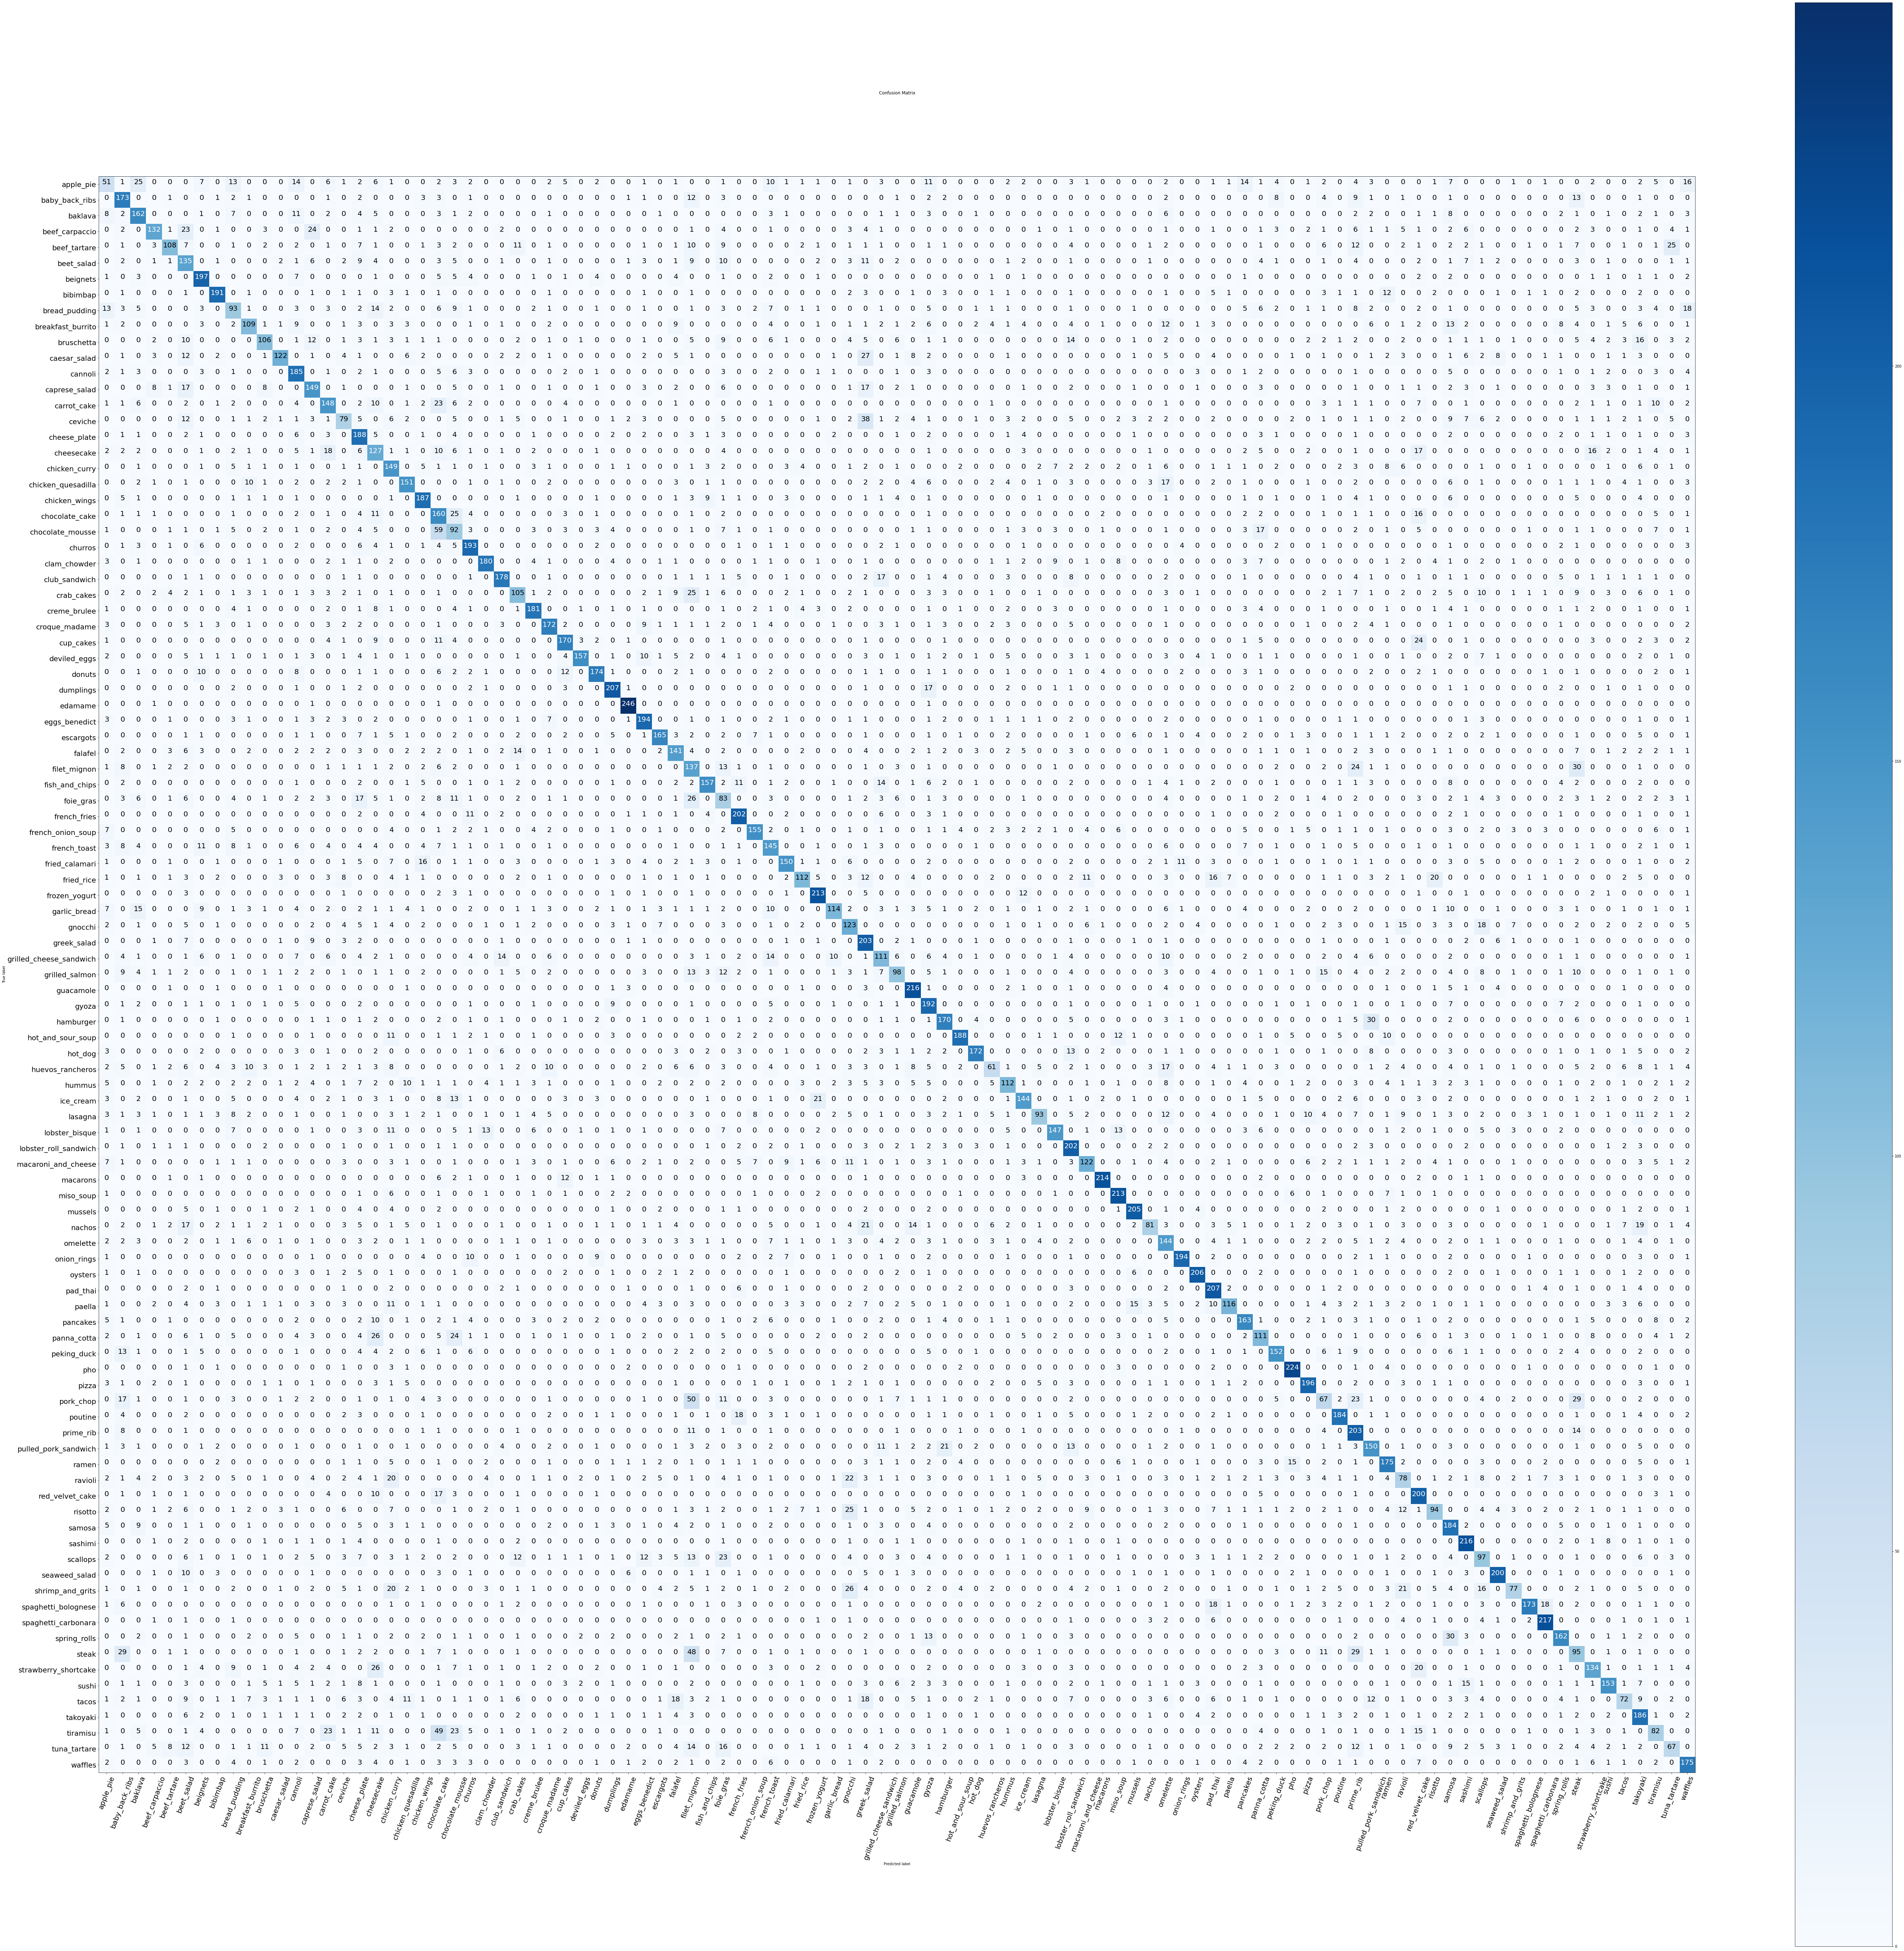

In [150]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

## **Classification Report (precision, recall, F1 score)** 

In [151]:
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [152]:
# Get a classification report dictionary 
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [153]:
classification_report_dict["100"]["f1-score"]

0.641025641025641

In [154]:
# Create a dictionary with key:value pair as class_names:F1 score
class_f1_scores = {}

# Loop through classification report disctory items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    # Add class names and f1_scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [155]:
# Turn the f1-score into dataframe for visualization
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [156]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

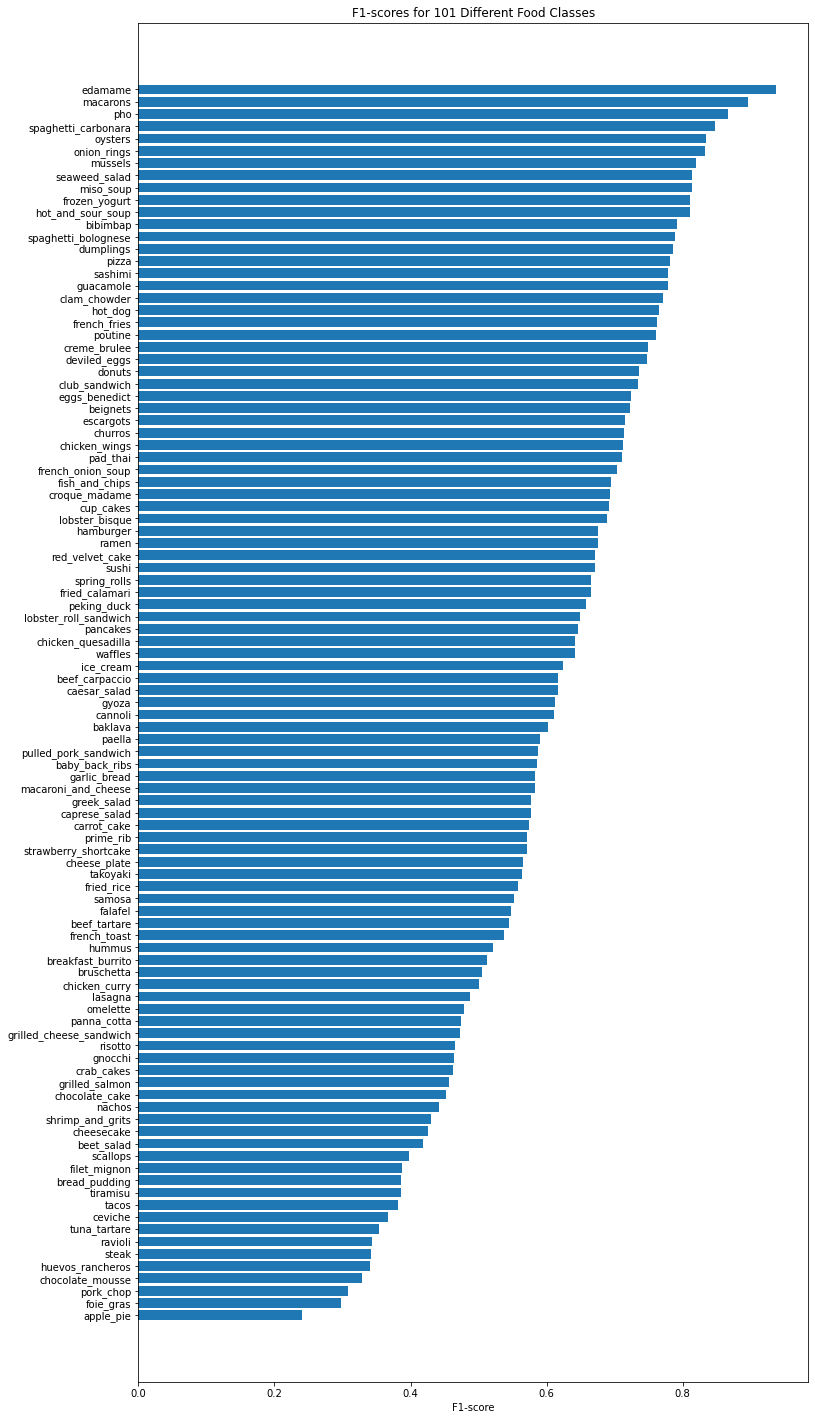

In [157]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes")
ax.invert_yaxis();

# Visualizing predictions on test images

Time for the real test. Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:
* Read in a target image filepath using [`tf.io.read_file()`](https://www.tensorflow.org/api_docs/python/tf/io/read_file).
* Turn the image into a `Tensor` using [`tf.io.decode_image()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_image).
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize).
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [158]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Image loading and preprocessing function ready.

Now let's write some code to: 

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

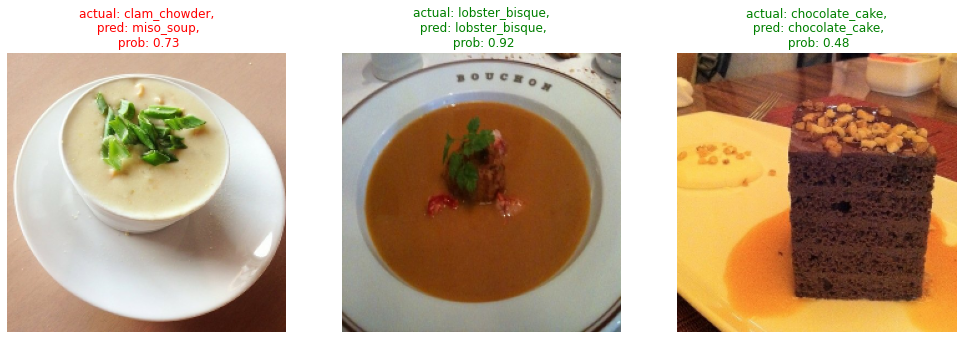

In [170]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name},\n pred: {pred_class},\n prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

# Finding the most wrong predictions

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These **most wrong** predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:
1. Get all of the image file paths in the test dataset using the [`list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
  * **Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [171]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:
* Their ground truth labels (`y_labels`).
* The class the model predicted (`pred_classes`).
* The maximum prediction probabilitity value (`pred_probs.max(axis=1)`).
* The ground truth class names.
* The predicted class names. 

In [173]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  ...      y_pred_classname
0  b'101_food_classes_10_percent/test/apple_pie/1...  ...                 gyoza
1  b'101_food_classes_10_percent/test/apple_pie/1...  ...             apple_pie
2  b'101_food_classes_10_percent/test/apple_pie/1...  ...             apple_pie
3  b'101_food_classes_10_percent/test/apple_pie/1...  ...  pulled_pork_sandwich
4  b'101_food_classes_10_percent/test/apple_pie/1...  ...             prime_rib

[5 rows x 6 columns]

In [174]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'101_food_classes_10_percent/test/apple_pie/1...  ...         False
1  b'101_food_classes_10_percent/test/apple_pie/1...  ...          True
2  b'101_food_classes_10_percent/test/apple_pie/1...  ...          True
3  b'101_food_classes_10_percent/test/apple_pie/1...  ...         False
4  b'101_food_classes_10_percent/test/apple_pie/1...  ...         False

[5 rows x 7 columns]

In [175]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  ...  pred_correct
21810  b'101_food_classes_10_percent/test/scallops/17...  ...         False
231    b'101_food_classes_10_percent/test/apple_pie/8...  ...         False
15359  b'101_food_classes_10_percent/test/lobster_rol...  ...         False
23539  b'101_food_classes_10_percent/test/strawberry_...  ...         False
21400  b'101_food_classes_10_percent/test/samosa/3140...  ...         False
24540  b'101_food_classes_10_percent/test/tiramisu/16...  ...         False
2511   b'101_food_classes_10_percent/test/bruschetta/...  ...         False
5574   b'101_food_classes_10_percent/test/chocolate_m...  ...         False
17855  b'101_food_classes_10_percent/test/paella/2314...  ...         False
23797  b'101_food_classes_10_percent/test/sushi/16593...  ...         False
18001  b'101_food_classes_10_percent/test/pancakes/10...  ...         False
11642  b'101_food_classes_10_percent/test/garlic_brea...  ...         False
10847  b'101_food_classes_10_percent/test/fried_calam...  ...         False
23631  b'101_food_classes_10_percent/test/strawberry_...  ...         False
1155   b'101_food_classes_10_percent/test/beef_tartar...  ...         False
10854  b'101_food_classes_10_percent/test/fried_calam...  ...         False
23904  b'101_food_classes_10_percent/test/sushi/33652...  ...         False
7316   b'101_food_classes_10_percent/test/cup_cakes/1...  ...         False
13144  b'101_food_classes_10_percent/test/gyoza/31214...  ...         False
10880  b'101_food_classes_10_percent/test/fried_calam...  ...         False

[20 rows x 7 columns]

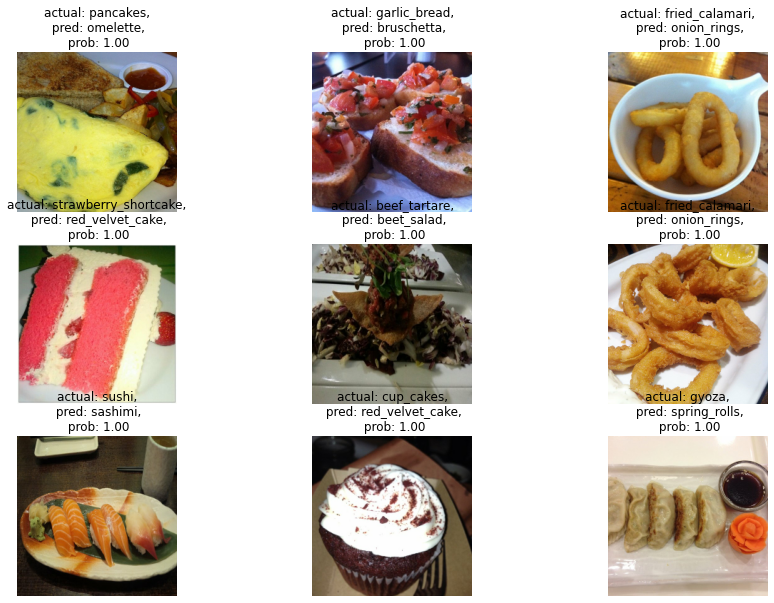

In [180]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true},\n pred: {y_pred},\n prob: {pred_prob:.2f}")
  plt.axis(False)

# Test out the big dog model on test images as well as custom images of food 

So far we've visualized some our model's predictions from the test dataset but it's time for the real test: using our model to make predictions on our own custom images of food.

For this you might want to upload your own images to Google Colab or by putting them in a folder you can load into the notebook.

In my case, I've prepared my own small dataset of six or so images of various foods.

Let's download them and unzip them.

In [177]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2021-08-07 06:06:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  40.6MB/s    in 0.3s    

2021-08-07 06:06:36 (40.6 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [178]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg']

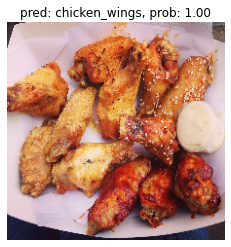

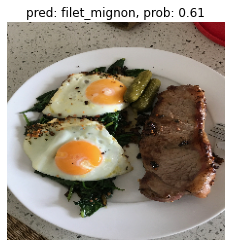

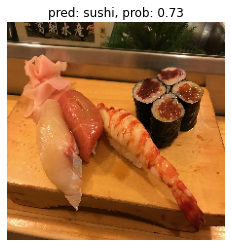

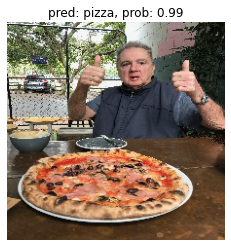

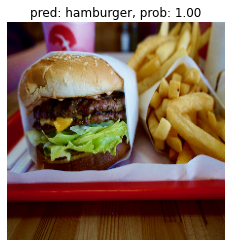

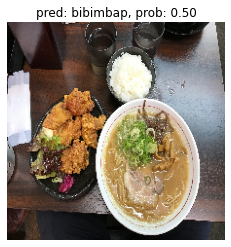

In [179]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)